In [2]:
# Import packages

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random

### LOAD A RANDOM SAMPLE OF THE DATA

In [4]:
# TAKE A SAMPLE OF DATA
filename = 'C:/Users/tomas/Documents/socialdatascience/user_data_public.csv'
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 1000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list

df_master = pd.read_csv(filename, header='infer', skiprows=skip, dtype = object)


In [5]:
#IMPORTANT : THIS IS IN EXCEL FORMAT, CHANGE TO CSV IF YOUR FILE IS NOT XLSX
df_q_list = pd.read_excel("C:/Users/tomas/Documents/socialdatascience/question_data.xlsx")

In [6]:
#Count not missing each row i.e: number of answered questions by each preson:
df_master["answered_questions"] = df_master.notnull().sum(axis=1)

# Take only questions with n answers and put the questions in a column
#df_q.N.plot(kind="hist")

n_answers = 20000
df_keep = pd.DataFrame()
df_keep['keep_questions'] = df_q_list[df_q_list['N']>n_answers].index

In [7]:
#Keep only questions that are also in master dataframe
df_keep = df_keep[df_keep["keep_questions"].isin(list(df_master.columns.values))]

#Choose only rows with at least 1000 answered questions
df_clean_question = df_master[df_master["answered_questions"]>1000]

#Create new dataset with only most answered questions
df_clean_v1 = df_clean_question[list(df_keep["keep_questions"])]

In [8]:

#Create dummy for sexual orientation, where 1 = NOT STRAIGHT#Create 
sexual_orientation = []
for x in df_clean_v1['d_orientation']:
    if pd.isnull(x):
        sexual_orientation.append(1) #Since we have persons answered over a 1000 questions, so if they have not answered their sexual orientation we assume they are either uncertain or dont want to disclose because of fear of persecution/judgement from peers
    elif x != "Straight":
        sexual_orientation.append(1)
    else:
        sexual_orientation.append(0)

#Turn it into a dataframe and put labels from dataframe on
y = pd.DataFrame(sexual_orientation, index = df_clean_v1.index)

# Drop sexual orientation from master dataframe
df_clean_v1.drop(columns = ["d_orientation"], inplace = True)
print()

C:\Users\tomas\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
#Remove the most problematic questions, and them make all of the categorical variables dummiew
df_prep = df_clean_v1.drop(columns = ["q546", "q1040"])
df_dummy = pd.get_dummies(df_prep, dummy_na = False) #When missing giver 0 to all dummies created for the quesion with the missing value
#df_dummy.fillna(value = -1, inplace = True) #If missing insert -1 # This code does not work
X = df_dummy

#INSERT MISSING VALUES BACK INTO THE DUMMIES FOR LATER IMPUTER
for i in list(df_keep["keep_questions"].head()):
    X.loc[df_prep[i].isnull(), X.columns.str.startswith(i+"_")] = np.nan

In [10]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Imputer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)


### THIS IS A TEST USING A DECISION TREE

In [30]:
#IMPUTER REPLACE MISSINGS WITH THE MEAN OF THE COLUMN

tree = DecisionTreeClassifier(criterion='gini', max_depth= 4, random_state=1)

im = Imputer()
X_train = im.fit_transform(X_train)
X_test = im.fit_transform(X_test)

# FIT AND PREDICT THE TREE
tree.fit(X_train, y_train)
tree_predict = pd.DataFrame(tree.predict(X_test),index = y_test.index)

print(accuracy_score(y_test, tree_predict)) #This shows the accuracy of our decision tree
print(y_test.mean()) #This shows how many not straight rows in the dataset

0.8969072164948454
0    0.164948
dtype: float64


### Testing a Random Forest Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier

## This is a test with DEFAULT values

rf = RandomForestClassifier(random_state=1)

# FIT AND PREDICT THE TREE
rf.fit(X_train, y_train.values.ravel())
forest_predict = pd.DataFrame(rf.predict(X_test),index = y_test.index)
print(accuracy_score(y_test, forest_predict)) #This shows the accuracy of our decision tree
print(y_test.mean()) #This shows how many not straight rows in the dataset

0.845360824742268
0    0.164948
dtype: float64


In [65]:
# THIS GIVES YOU CLASS PROBABILITIES, WHATEVER THE HELL THAT IS

tprob = tree.predict_proba(X_train)
rfprob = clf_rf.predict_proba(X_train)

In [68]:
## Returns the mean accuracy on the given test data and labels.

print("In-sample prediction accuracy: ", rf.score(X_train, y_train))
print("Out-of-sample prediction accuracy: ", rf.score(X_test, y_test))

In-sample prediction accuracy:  0.9821428571428571
Out-of-sample prediction accuracy:  0.845360824742268


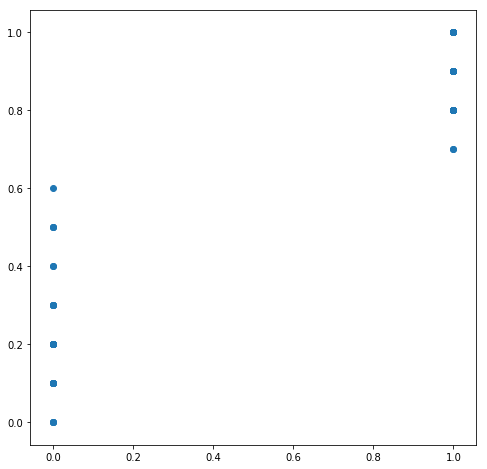

In [71]:
# fig, ax = plt.subplots(1,1,figsize=(8,8))

# ax.scatter(tprob[:,0], rfprob[:,0])
#ax.plot(tprob[1])

In [135]:
## NOW, TRY TESTING FOR DIFFERENT PARAMETERS:

from sklearn.metrics import mean_squared_error as mse

acc = np.empty((10,10))
errors = np.empty((10,10))

max_depth = range(1,11)
n_estimators = range(1,11)

for i in max_depth:
    for x in n_estimators:

        rf = RandomForestClassifier(random_state=1, max_depth=i, n_estimators=x)

        # FIT AND PREDICT THE TREE
        rf.fit(X_train, y_train.values.ravel())
        forest_predict = pd.DataFrame(rf.predict(X_test),index = y_test.index)

        acc[i,x] = (accuracy_score(y_test, forest_predict)) #This shows the accuracy of our decision tree
        errors[i,x] = (mse(forest_predict, y_test))

print(y_test.mean()) #This shows how many not straight rows in the dataset

IndexError: index 10 is out of bounds for axis 1 with size 10

In [136]:
acc[10,10]

IndexError: index 10 is out of bounds for axis 0 with size 10

In [127]:
print(acc)
print()
print(errors)

[[ 0.00000000e+000  7.72688307e-315  3.71537366e-321              nan
  -3.72989430e-303  0.00000000e+000  4.36515493e-095  1.39030923e+093
   3.11065042e+088  8.83512175e+025]
 [ 1.42511465e+064  8.35051546e-001  8.35051546e-001  8.35051546e-001
   8.35051546e-001  8.35051546e-001  8.35051546e-001  8.35051546e-001
   8.35051546e-001  8.35051546e-001]
 [ 7.52736939e+252  1.96265966e+243  3.74168445e+233  2.03537408e-110
   7.98071486e+151  2.17236061e-153  8.03272539e-096  2.03789008e+180
   1.67791843e+243  1.69201539e+190]
 [ 9.15531747e+135  2.45886213e+198  7.98071334e+151  4.08149543e+223
   2.19993033e-152  2.03781299e+180  1.67791843e+243  6.12743633e-154
   3.08068367e+185  3.87204162e+228]
 [ 9.21020653e+016  3.29368402e+180  1.38519249e+219  1.66377202e-071
   2.64180602e+180  2.92314468e+222  3.99281087e+252  4.07192861e+223
   6.01347002e-154  6.05206351e-153]
 [ 7.86625803e+020  3.17464775e-153  6.12743542e-154  3.08068367e+185
   3.59067329e+252  8.22461583e+151  3.118502

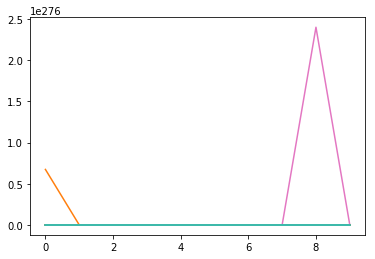

In [128]:
fig, ax =  plt.subplots(1,1)

plt.plot(errors)
plt.plot(acc)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

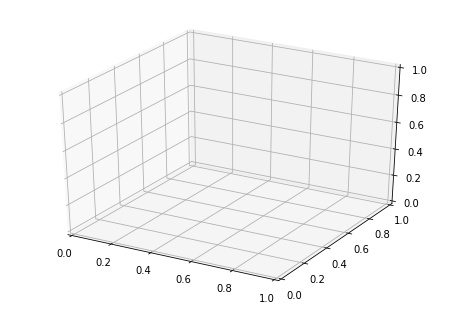

In [130]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.plot(acc, errors)